In [1]:

import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scvi
import pandas as pd
import seaborn as sns
from scipy.spatial import distance_matrix

sc.set_figure_params(figsize=(4, 4))
save_dir = tempfile.TemporaryDirectory()
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

from scvi.external import resolvi
import scvi.external.resolvi as resolvi
from scvi.external.resolvi import RESOLVI

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
Seed set to 0


Last run with scvi-tools version: 1.3.0


In [2]:
path_to_query_adata = '/mnt/sata3/Dhruv_Analysis_1/2025_05_22_IL-15_KO/combined/06_resolvi.h5ad'

In [3]:
query_adata = sc.read(path_to_query_adata)

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [11]:
resolvi = scvi.external.resolvi.RESOLVI.load("query_resolvi.model", query_adata)

INFO     File query_resolvi.model/model.pt already downloaded                                                      


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 414450 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [59]:
batch_dict = {'batch_1': 'IL15 KO, IL7R', 'batch_2':'IL15KO, IgG', 'batch_4': 'B6, IgG', 'batch_3': 'B6, IgG'}
query_adata.obs['mapped_batch'] = query_adata.obs['batch'].map(batch_dict)

In [60]:
xist_positive = (query_adata.layers['counts'][:, query_adata.var.index == 'Xist'] > 0).flatten()

In [61]:
query_P14s = query_adata[(query_adata.obs["resolvi_predicted"].isin(['Cd8_T-Cell_P14', 'Cd8_T-Cell_ab+'])) & xist_positive]

In [63]:
batch1 = 'IL15KO, IgG'
batch2 = 'B6, IgG'

de_result_importance = resolvi.differential_expression(
    query_P14s,
    groupby="mapped_batch",
    group1=batch1,
    group2=batch2,
    weights="importance",
    pseudocounts=1e-2,
    delta=0.05,
    filter_outlier_cells=True,
    mode="change",
    test_mode="three",
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/adjustText/__init__.py:419: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  ax.figure.draw_without_rendering()
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


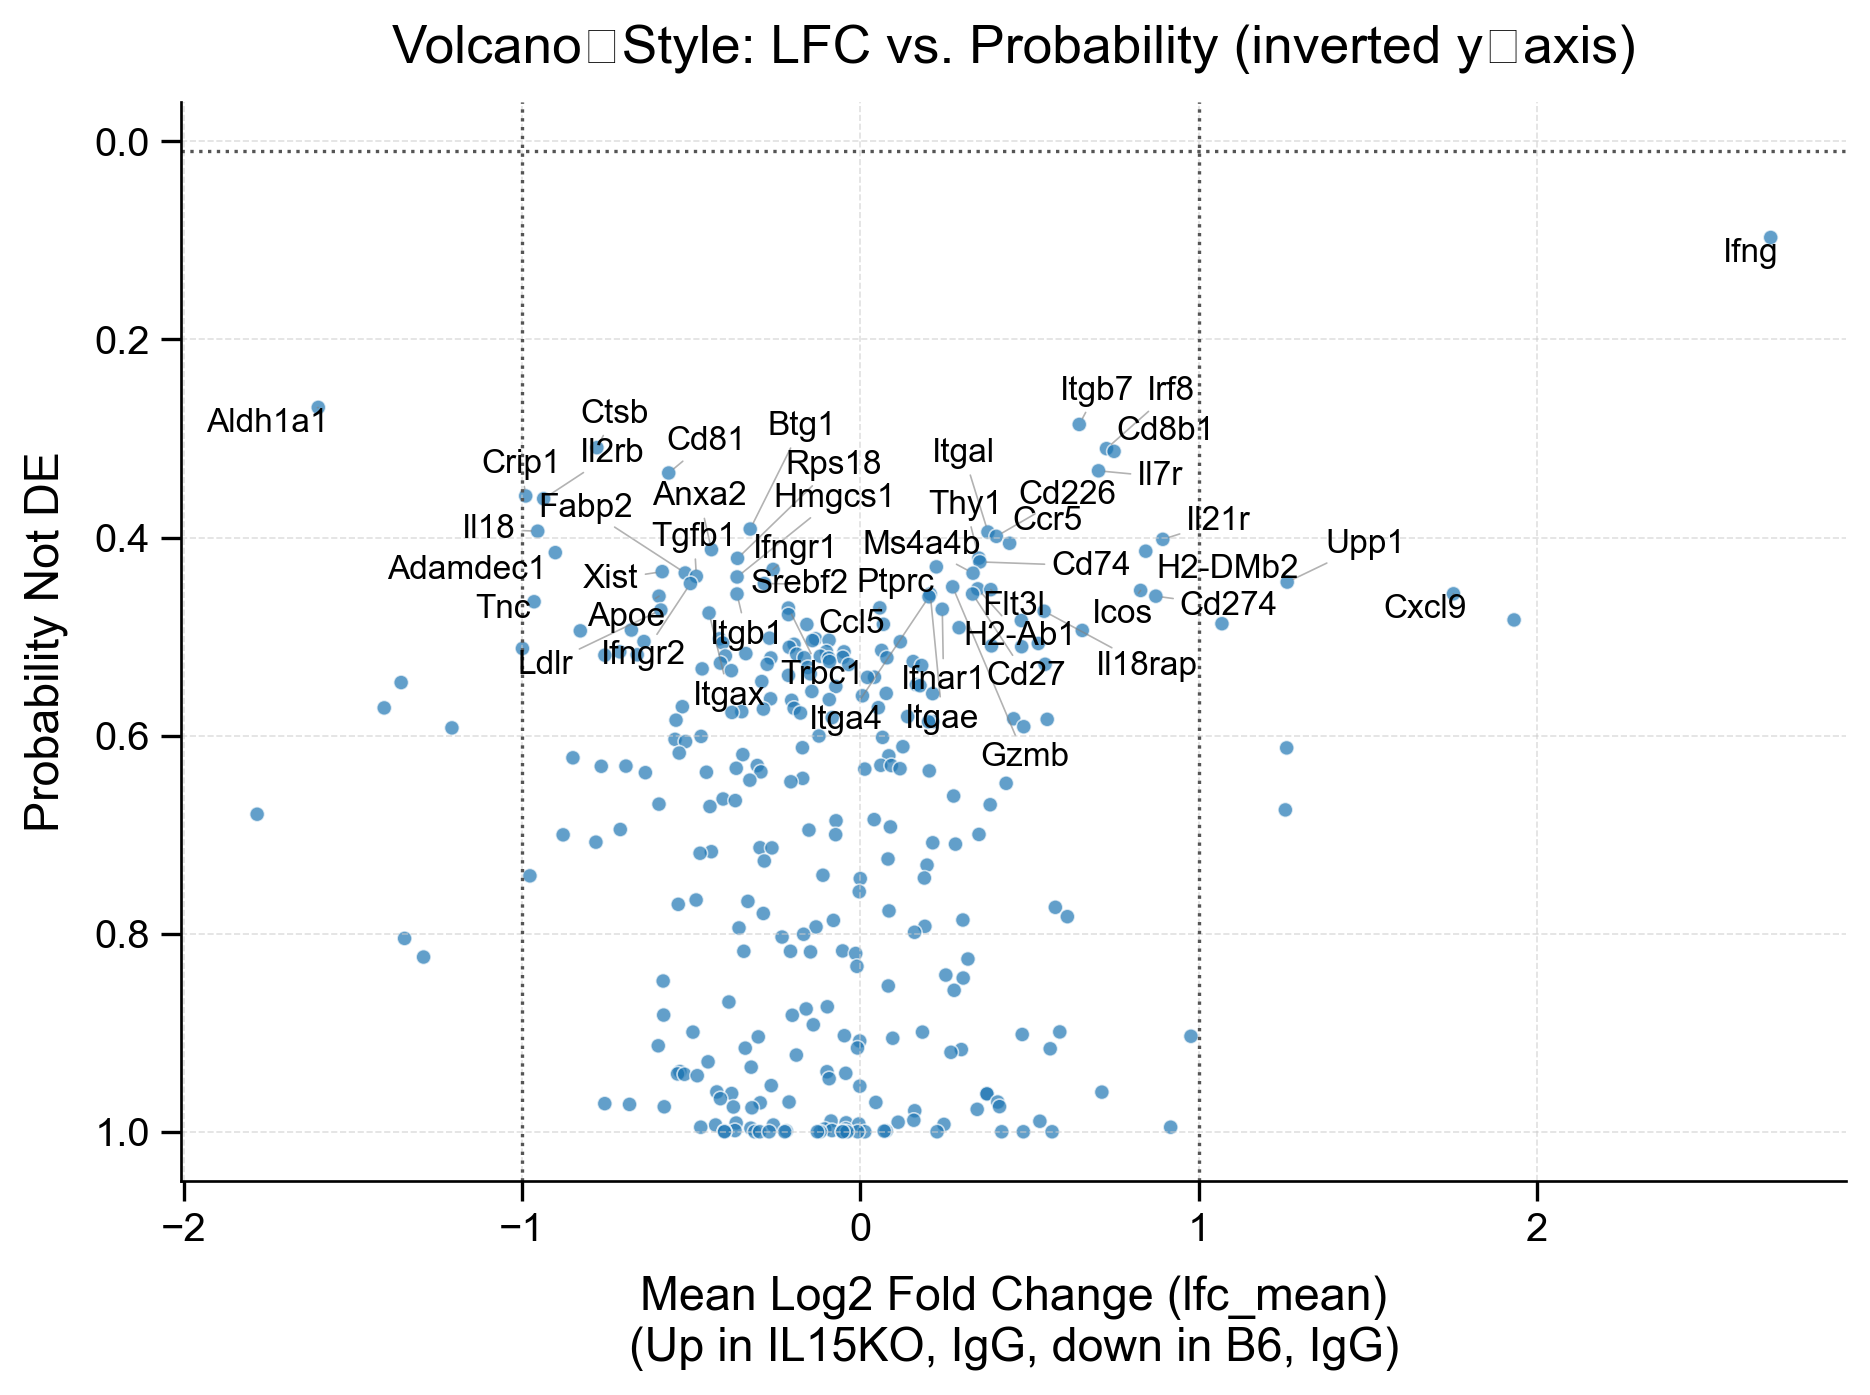

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text  # pip install adjustText

# (1) Extract fold‐changes and raw probability
lfc = de_result_importance['lfc_mean']
proba = de_result_importance['proba_not_de']

# (2) Define significance mask using the same thresholds, but on raw proba:
#     – Previously: sig_mask = (|lfc| > 1.0) & (neg_log_p > 2) 
#       which is equivalent to (|lfc| > 1.0) & (proba < 0.01)
sig_mask = (np.abs(lfc) > 1.0) & (proba < 0.01)
colors   = np.where(sig_mask, '#d62728', '#1f77b4')
sizes    = np.where(sig_mask, 50, 20)

plt.figure(figsize=(8, 6), dpi=120)

# (3) Scatter plot of LFC vs. raw probability
plt.scatter(
    lfc,
    proba,
    c=colors,
    s=sizes,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# (4) Axis labels and title (updated y‐label to reflect raw probability)
plt.xlabel(
    f'Mean Log2 Fold Change (lfc_mean)\n(Up in {batch1}, down in {batch2})',
    fontsize=14,
    labelpad=8
)
plt.ylabel(
    'Probability Not DE',
    fontsize=14,
    labelpad=8
)
plt.title(
    'Volcano‐Style: LFC vs. Probability (inverted y‐axis)',
    fontsize=16,
    pad=12
)

# (5) Invert the y‐axis so that smaller proba (more significant) are at the top
plt.gca().invert_yaxis()

# (6) Grid and spines styling
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.6)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(direction='out', length=6, width=1)

# (7) Threshold lines:
#     – verticals at LFC = ±1.0
#     – horizontal at Probability = 0.01 (same as neg_log_p = 2)
plt.axhline(y=0.01, color='#555555', linestyle=':', linewidth=1)   # proba = 0.01
plt.axvline(x=1.0,  color='#555555', linestyle=':', linewidth=1)
plt.axvline(x=-1.0, color='#555555', linestyle=':', linewidth=1)

# (8) Annotate top N genes by smallest probability (i.e. most significant → lowest proba)
top_n = 50
order = np.argsort(proba.values)[:top_n]  # ascending order of proba_not_de
texts = []
for idx in order:
    x_val = lfc.iloc[idx]
    y_val = proba.iloc[idx]
    gene  = de_result_importance.index[idx]
    texts.append(
        plt.text(
            x_val,
            y_val,
            gene,
            fontsize=10,
            ha='center',
            va='center',
            color='black'
        )
    )

# (9) Use adjustText to prevent overlap (move labels vertically if needed)
adjust_text(
    texts,
    only_move={'points': 'y', 'texts': 'y'},
    arrowprops={'arrowstyle': '-', 'color': 'gray', 'lw': 0.5, 'alpha': 0.6}
)

plt.tight_layout()
plt.show()


In [65]:
batch1 = 'IL15 KO, IL7R'
batch2 = 'B6, IgG'

de_result_importance = resolvi.differential_expression(
    query_P14s,
    groupby="mapped_batch",
    group1=batch1,
    group2=batch2,
    weights="importance",
    pseudocounts=1e-2,
    delta=0.05,
    filter_outlier_cells=True,
    mode="change",
    test_mode="three",
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/adjustText/__init__.py:419: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  ax.figure.draw_without_rendering()
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


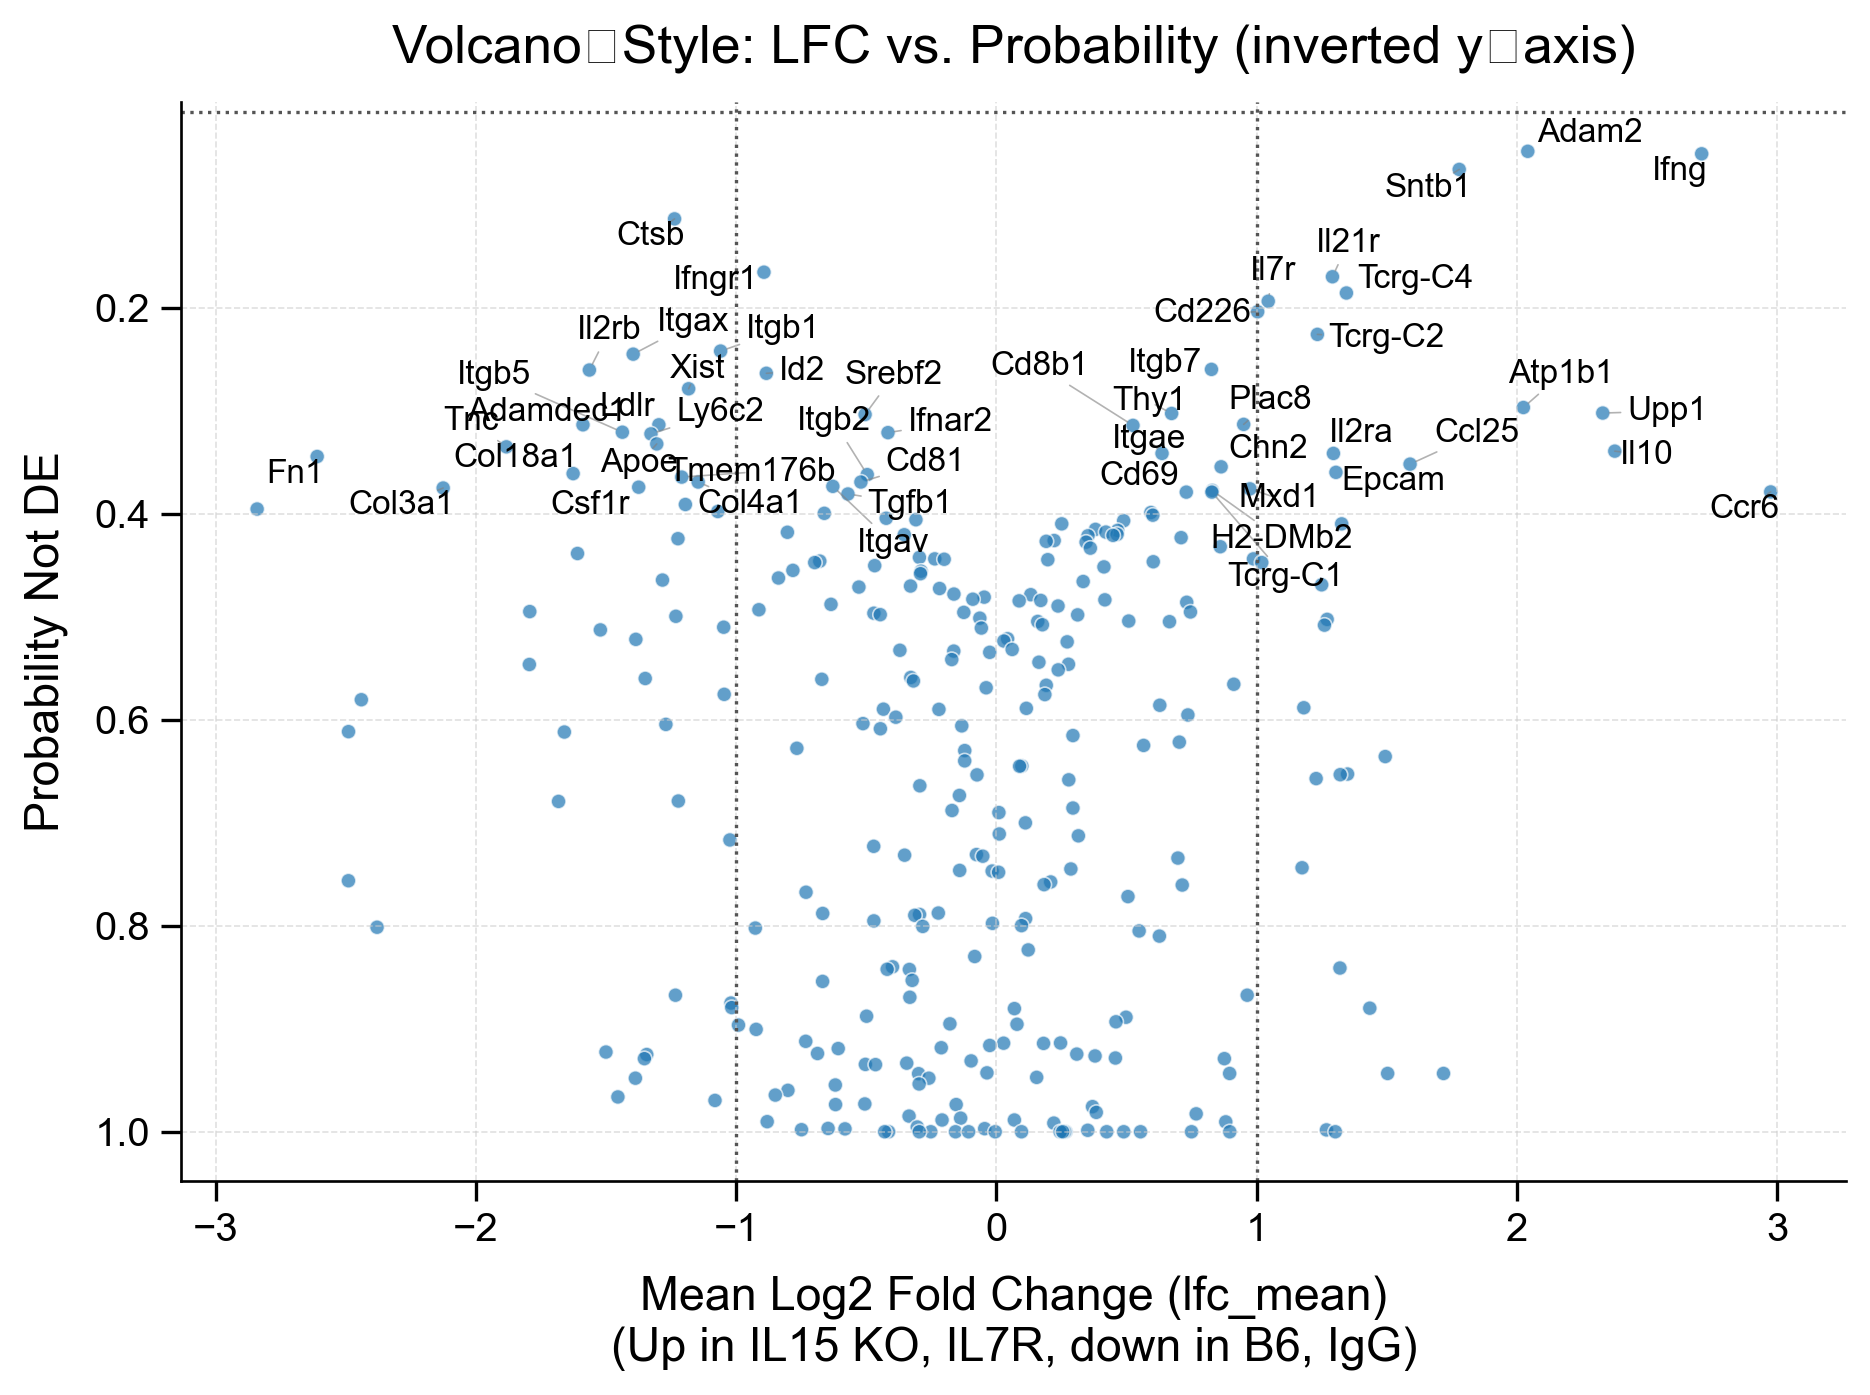

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text  # pip install adjustText

# (1) Extract fold‐changes and raw probability
lfc = de_result_importance['lfc_mean']
proba = de_result_importance['proba_not_de']

# (2) Define significance mask using the same thresholds, but on raw proba:
#     – Previously: sig_mask = (|lfc| > 1.0) & (neg_log_p > 2) 
#       which is equivalent to (|lfc| > 1.0) & (proba < 0.01)
sig_mask = (np.abs(lfc) > 1.0) & (proba < 0.01)
colors   = np.where(sig_mask, '#d62728', '#1f77b4')
sizes    = np.where(sig_mask, 50, 20)

plt.figure(figsize=(8, 6), dpi=120)

# (3) Scatter plot of LFC vs. raw probability
plt.scatter(
    lfc,
    proba,
    c=colors,
    s=sizes,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# (4) Axis labels and title (updated y‐label to reflect raw probability)
plt.xlabel(
    f'Mean Log2 Fold Change (lfc_mean)\n(Up in {batch1}, down in {batch2})',
    fontsize=14,
    labelpad=8
)
plt.ylabel(
    'Probability Not DE',
    fontsize=14,
    labelpad=8
)
plt.title(
    'Volcano‐Style: LFC vs. Probability (inverted y‐axis)',
    fontsize=16,
    pad=12
)

# (5) Invert the y‐axis so that smaller proba (more significant) are at the top
plt.gca().invert_yaxis()

# (6) Grid and spines styling
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.6)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(direction='out', length=6, width=1)

# (7) Threshold lines:
#     – verticals at LFC = ±1.0
#     – horizontal at Probability = 0.01 (same as neg_log_p = 2)
plt.axhline(y=0.01, color='#555555', linestyle=':', linewidth=1)   # proba = 0.01
plt.axvline(x=1.0,  color='#555555', linestyle=':', linewidth=1)
plt.axvline(x=-1.0, color='#555555', linestyle=':', linewidth=1)

# (8) Annotate top N genes by smallest probability (i.e. most significant → lowest proba)
top_n = 50
order = np.argsort(proba.values)[:top_n]  # ascending order of proba_not_de
texts = []
for idx in order:
    x_val = lfc.iloc[idx]
    y_val = proba.iloc[idx]
    gene  = de_result_importance.index[idx]
    texts.append(
        plt.text(
            x_val,
            y_val,
            gene,
            fontsize=10,
            ha='center',
            va='center',
            color='black'
        )
    )

# (9) Use adjustText to prevent overlap (move labels vertically if needed)
adjust_text(
    texts,
    only_move={'points': 'y', 'texts': 'y'},
    arrowprops={'arrowstyle': '-', 'color': 'gray', 'lw': 0.5, 'alpha': 0.6}
)

plt.tight_layout()
plt.show()


In [67]:
batch1 = 'IL15 KO, IL7R'
batch2 = 'IL15KO, IgG'

de_result_importance = resolvi.differential_expression(
    query_P14s,
    groupby="mapped_batch",
    group1=batch1,
    group2=batch2,
    weights="importance",
    pseudocounts=1e-2,
    delta=0.05,
    filter_outlier_cells=True,
    mode="change",
    test_mode="three",
)


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/adjustText/__init__.py:419: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  ax.figure.draw_without_rendering()
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


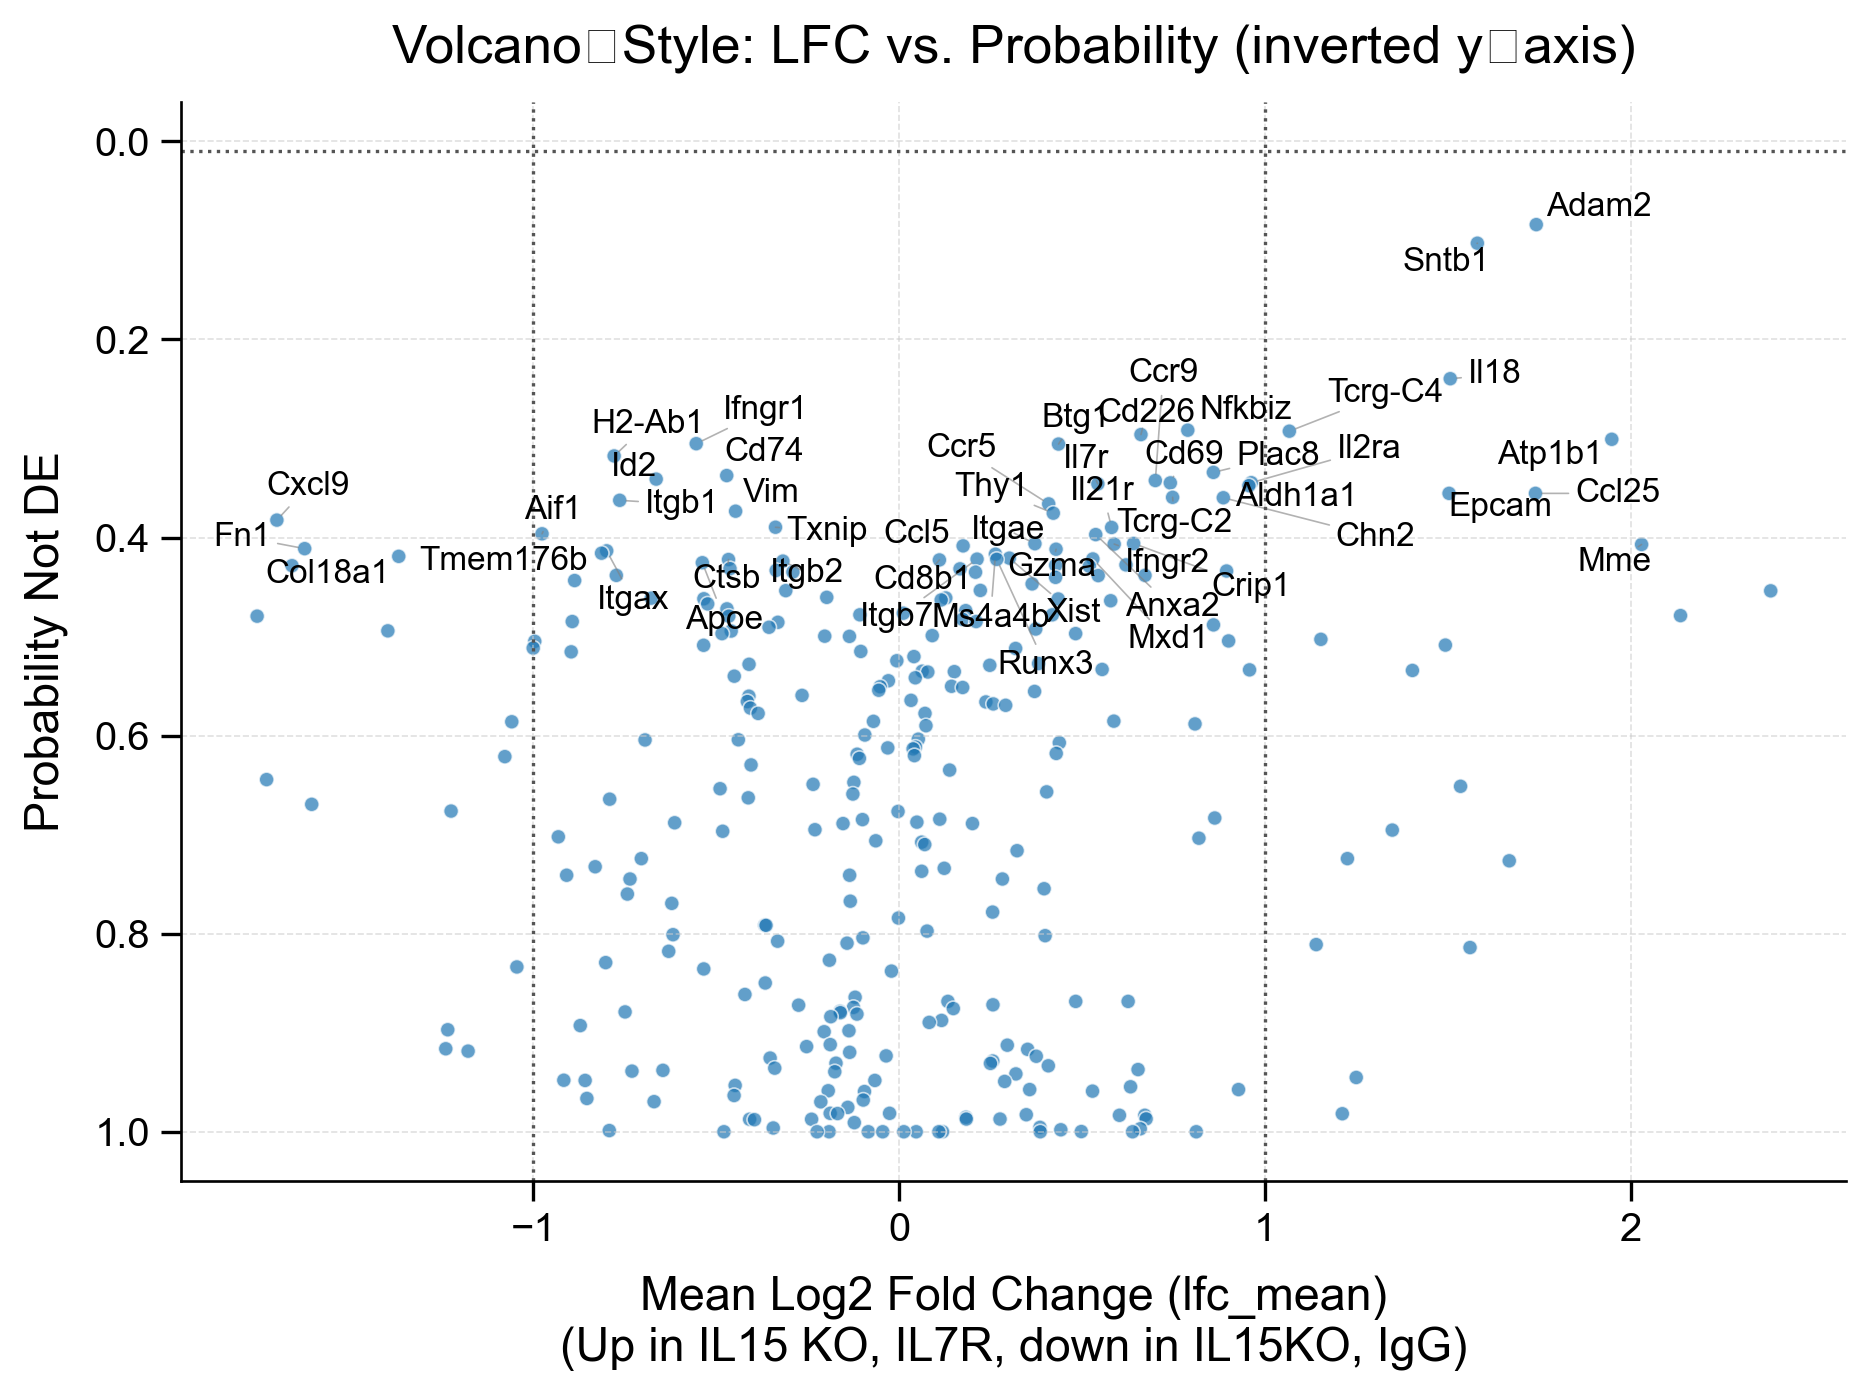

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text  # pip install adjustText

# (1) Extract fold‐changes and raw probability
lfc = de_result_importance['lfc_mean']
proba = de_result_importance['proba_not_de']

# (2) Define significance mask using the same thresholds, but on raw proba:
#     – Previously: sig_mask = (|lfc| > 1.0) & (neg_log_p > 2) 
#       which is equivalent to (|lfc| > 1.0) & (proba < 0.01)
sig_mask = (np.abs(lfc) > 1.0) & (proba < 0.01)
colors   = np.where(sig_mask, '#d62728', '#1f77b4')
sizes    = np.where(sig_mask, 50, 20)

plt.figure(figsize=(8, 6), dpi=120)

# (3) Scatter plot of LFC vs. raw probability
plt.scatter(
    lfc,
    proba,
    c=colors,
    s=sizes,
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# (4) Axis labels and title (updated y‐label to reflect raw probability)
plt.xlabel(
    f'Mean Log2 Fold Change (lfc_mean)\n(Up in {batch1}, down in {batch2})',
    fontsize=14,
    labelpad=8
)
plt.ylabel(
    'Probability Not DE',
    fontsize=14,
    labelpad=8
)
plt.title(
    'Volcano‐Style: LFC vs. Probability (inverted y‐axis)',
    fontsize=16,
    pad=12
)

# (5) Invert the y‐axis so that smaller proba (more significant) are at the top
plt.gca().invert_yaxis()

# (6) Grid and spines styling
plt.grid(which='major', linestyle='--', linewidth=0.5, alpha=0.6)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.8)
plt.gca().spines['bottom'].set_linewidth(0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().tick_params(direction='out', length=6, width=1)

# (7) Threshold lines:
#     – verticals at LFC = ±1.0
#     – horizontal at Probability = 0.01 (same as neg_log_p = 2)
plt.axhline(y=0.01, color='#555555', linestyle=':', linewidth=1)   # proba = 0.01
plt.axvline(x=1.0,  color='#555555', linestyle=':', linewidth=1)
plt.axvline(x=-1.0, color='#555555', linestyle=':', linewidth=1)

# (8) Annotate top N genes by smallest probability (i.e. most significant → lowest proba)
top_n = 50
order = np.argsort(proba.values)[:top_n]  # ascending order of proba_not_de
texts = []
for idx in order:
    x_val = lfc.iloc[idx]
    y_val = proba.iloc[idx]
    gene  = de_result_importance.index[idx]
    texts.append(
        plt.text(
            x_val,
            y_val,
            gene,
            fontsize=10,
            ha='center',
            va='center',
            color='black'
        )
    )

# (9) Use adjustText to prevent overlap (move labels vertically if needed)
adjust_text(
    texts,
    only_move={'points': 'y', 'texts': 'y'},
    arrowprops={'arrowstyle': '-', 'color': 'gray', 'lw': 0.5, 'alpha': 0.6}
)

plt.tight_layout()
plt.show()


In [16]:
copy_query = query_adata.copy()

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [8]:
supervised_resolvi = scvi.external.resolvi.RESOLVI.load("supervised_resolvi.model", sc.read("supervised_resolvi.model/timecourse.h5ad"))

INFO     File supervised_resolvi.model/model.pt already downloaded                                                 


/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 0 in adata.obs['_scvi_ind_x'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you

Training:   0%|          | 0/50 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


In [17]:
batch_dict = {'batch_1': 'IL15 KO, IL7R', 'batch_2':'IL15KO, IgG', 'batch_4': 'B6, IgG', 'batch_3': 'B6, IgG'}
copy_query.obs['mapped_batch_control'] = copy_query.obs['batch'].map(batch_dict)

In [18]:
copy_query.obs['is_P14'] = (copy_query.obs["resolvi_predicted"].isin(['Cd8_T-Cell_P14', 'Cd8_T-Cell_ab+'])) & xist_positive

In [19]:
copy_query.obs['mapped_batch_P14'] = copy_query.obs['mapped_batch_control'].astype(str) + '_' + copy_query.obs['is_P14'].astype(str)

In [25]:
batch1 = 'IL15 KO, IL7R_True'
batch2 = 'B6, IgG_True'
da_15_7 = resolvi.differential_niche_abundance(
    copy_query,
    groupby="mapped_batch_P14",
    group1=batch1,
    group2=batch2,
    neighbor_key="index_neighbor",
    test_mode="three",
    delta=0.05,
    pseudocounts=3e-2,
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling local variables, batch:   0%|          | 0/13 [00:00<?, ?it/s]

In [26]:
batch1 = 'IL15KO, IgG_True'
batch2 = 'B6, IgG_True'
da_15 = resolvi.differential_niche_abundance(
    copy_query,
    groupby="mapped_batch_P14",
    group1=batch1,
    group2=batch2,
    neighbor_key="index_neighbor",
    test_mode="three",
    delta=0.05,
    pseudocounts=3e-2,
)

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling local variables, batch:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling local variables, batch:   0%|          | 0/13 [00:00<?, ?it/s]

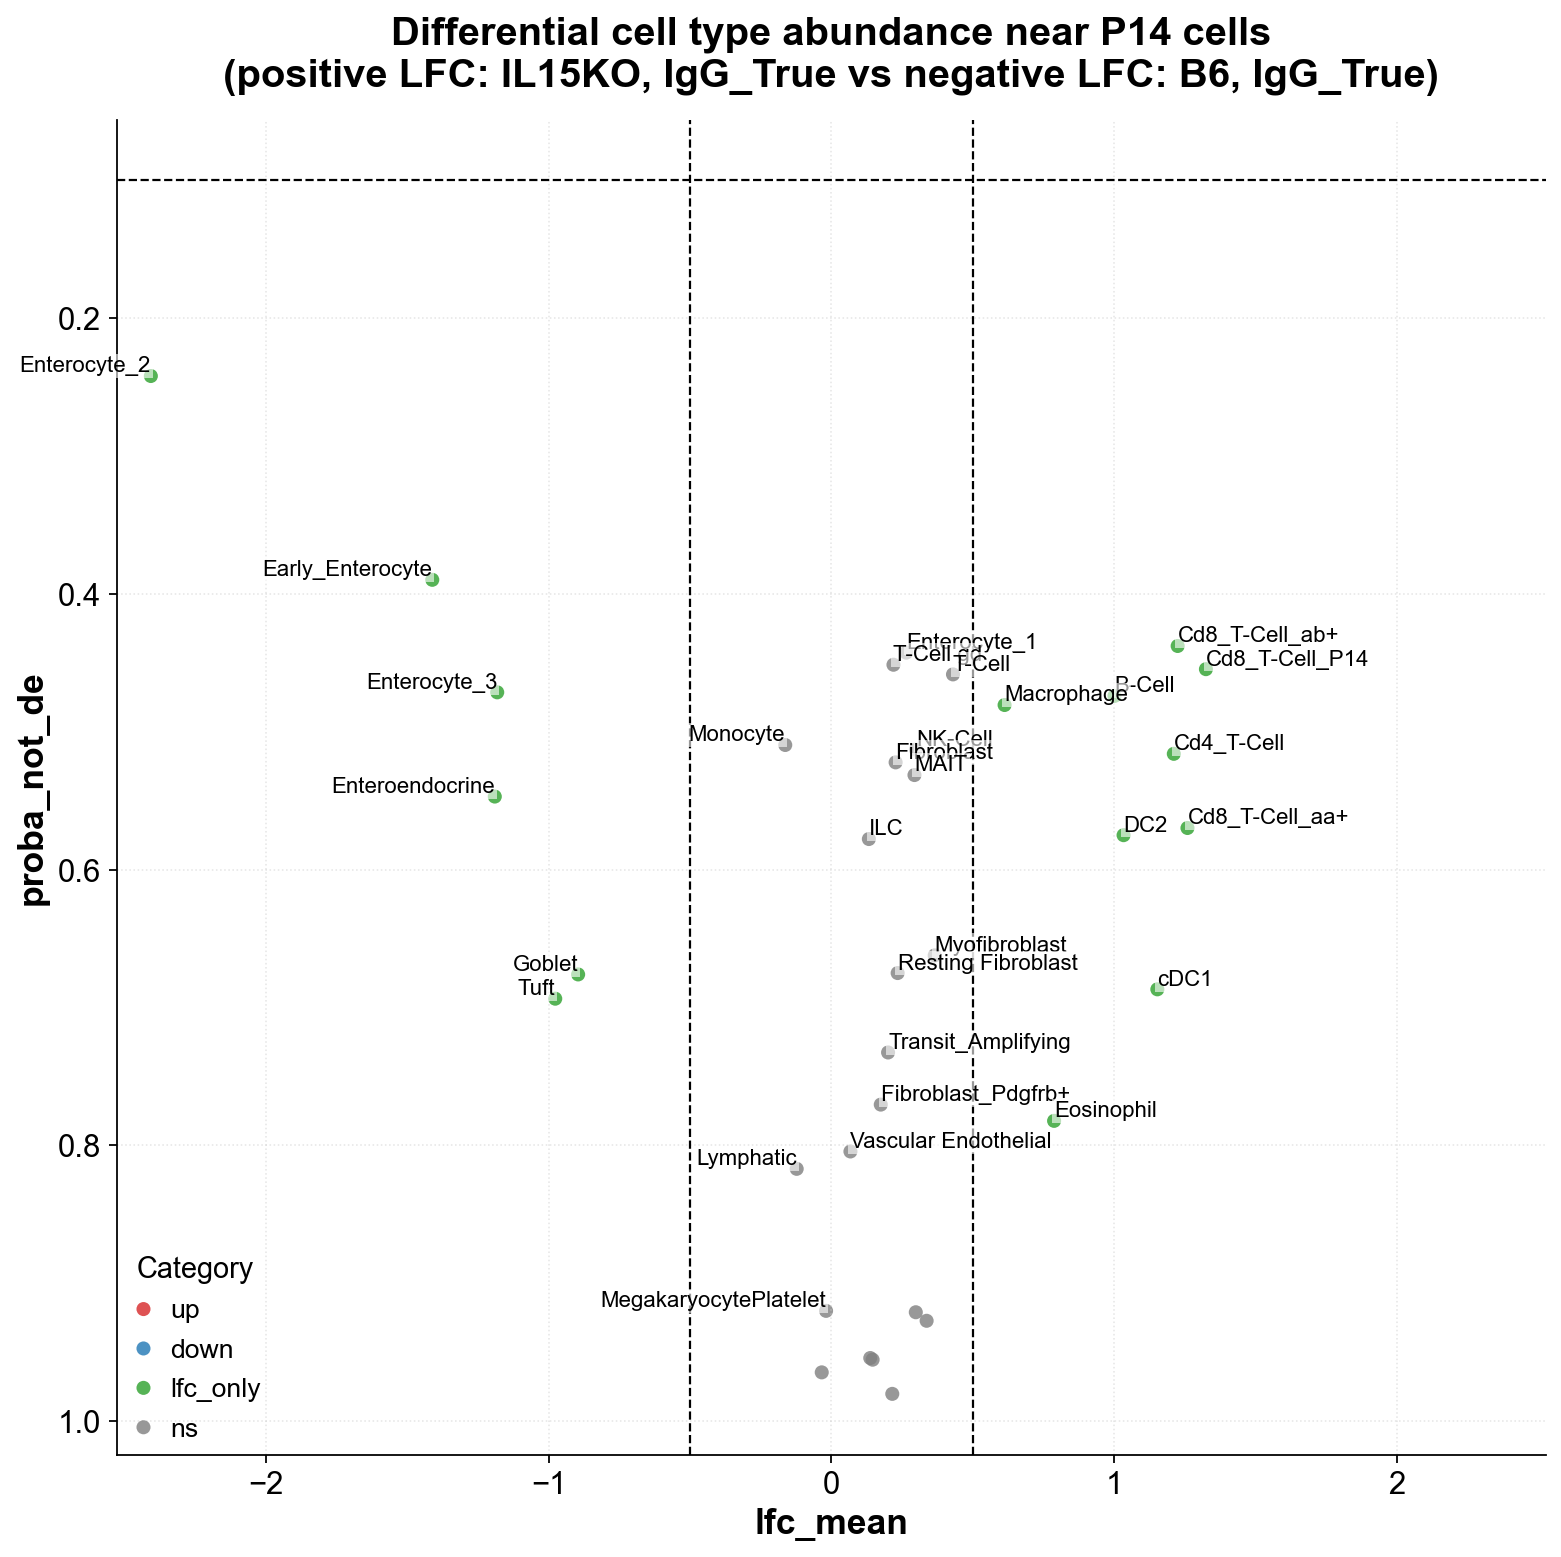

In [51]:
import matplotlib.pyplot as plt

def plot_volcano_matplotlib(
    df,
    batch1,
    batch2,
    x="lfc_mean",
    y="proba_not_de",
    sign_thr=0.1,
    lfc_thr=0.5,
    top_n=30,
    figsize=(10, 10),
    invert_y=True,
):
    # 1. Copy the DataFrame and define the “category” column
    df_plot = df.copy()
    df_plot["category"] = "ns"  # non‐significant by default

    # 2. Identify “up” and “down” by BOTH lfc + y
    up_mask = (df_plot[x] > lfc_thr) & (df_plot[y] < sign_thr)
    down_mask = (df_plot[x] < -lfc_thr) & (df_plot[y] < sign_thr)
    df_plot.loc[up_mask, "category"] = "up"
    df_plot.loc[down_mask, "category"] = "down"

    # 3. Identify all “large‐lfc” points (even if not y‐significant)
    lfc_only_mask = (df_plot[x].abs() > lfc_thr)
    df_plot.loc[lfc_only_mask & ~up_mask & ~down_mask, "category"] = "lfc_only"

    # 4. Define colors for each category (using tab colors for better contrast)
    colors = {
        "up": "#d62728",        # tab:red
        "down": "#1f77b4",      # tab:blue
        "lfc_only": "#2ca02c",  # tab:green
        "ns": "#7f7f7f",        # tab:gray
    }

    # 5. Create the figure and axes
    fig, ax = plt.subplots(figsize=figsize)

    # 6. Scatter each category separately
    for cat, color in colors.items():
        subset = df_plot[df_plot["category"] == cat]
        ax.scatter(
            subset[x],
            subset[y],
            c=color,
            label=cat,
            alpha=0.8,
            edgecolors="none",
            s=40,  # larger markers
        )

    # 7. Draw threshold lines
    ax.axvline(x=lfc_thr, linestyle="--", color="black", linewidth=1)
    ax.axvline(x=-lfc_thr, linestyle="--", color="black", linewidth=1)
    ax.axhline(y=sign_thr, linestyle="--", color="black", linewidth=1)

    # 8. Annotate the top N hits by smallest `y`
    top_hits = df_plot.nsmallest(top_n, y)
    for idx, row in top_hits.iterrows():
        xv = row[x]
        yv = row[y]
        ha = "right" if xv < 0 else "left"
        ax.text(
            xv,
            yv,
            s=str(idx),
            fontsize=10,  # larger annotation text
            ha=ha,
            va="bottom",
            color="black",
            bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", pad=1),
        )

    # 9. Force x‐axis to be symmetric around zero
    max_abs = df_plot[x].abs().max()
    pad = 0.05 * max_abs
    ax.set_xlim(-max_abs - pad, max_abs + pad)

    # 10. Set labels, title, and legend with larger fonts
    ax.set_xlabel(f"{x}", fontsize=16, fontweight="bold")
    ax.set_ylabel(f"{y}", fontsize=16, fontweight="bold")
    ax.set_title(
        f"Differential cell type abundance near P14 cells\n"
        f"(positive LFC: {batch1} vs negative LFC: {batch2})",
        fontsize=18,
        fontweight="semibold",
        pad=15,
    )
    leg = ax.legend(title="Category", fontsize=12, title_fontsize=13, frameon=False)
    for text in leg.get_texts():
        text.set_color("black")

    # 11. Improve tick label size and add grid
    ax.tick_params(axis="both", which="major", labelsize=14)
    ax.grid(True, linestyle=":", linewidth=0.7, alpha=0.5)

    # 12. Remove top/right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # 13. Optionally invert the y‐axis
    if invert_y:
        ax.invert_yaxis()

    fig.tight_layout()
    return fig, ax

batch1 = 'IL15KO, IgG_True'
batch2 = 'B6, IgG_True'
# Example usage (assuming `da_15`, `batch1`, and `batch2` are defined):
fig, ax = plot_volcano_matplotlib(
    da_15,
    batch1,
    batch2,
    x="lfc_mean",
    y="proba_not_de",
    sign_thr=0.1,
    lfc_thr=0.5,
    top_n=30,
    figsize=(10, 10),
    invert_y=True,
)

plt.show()


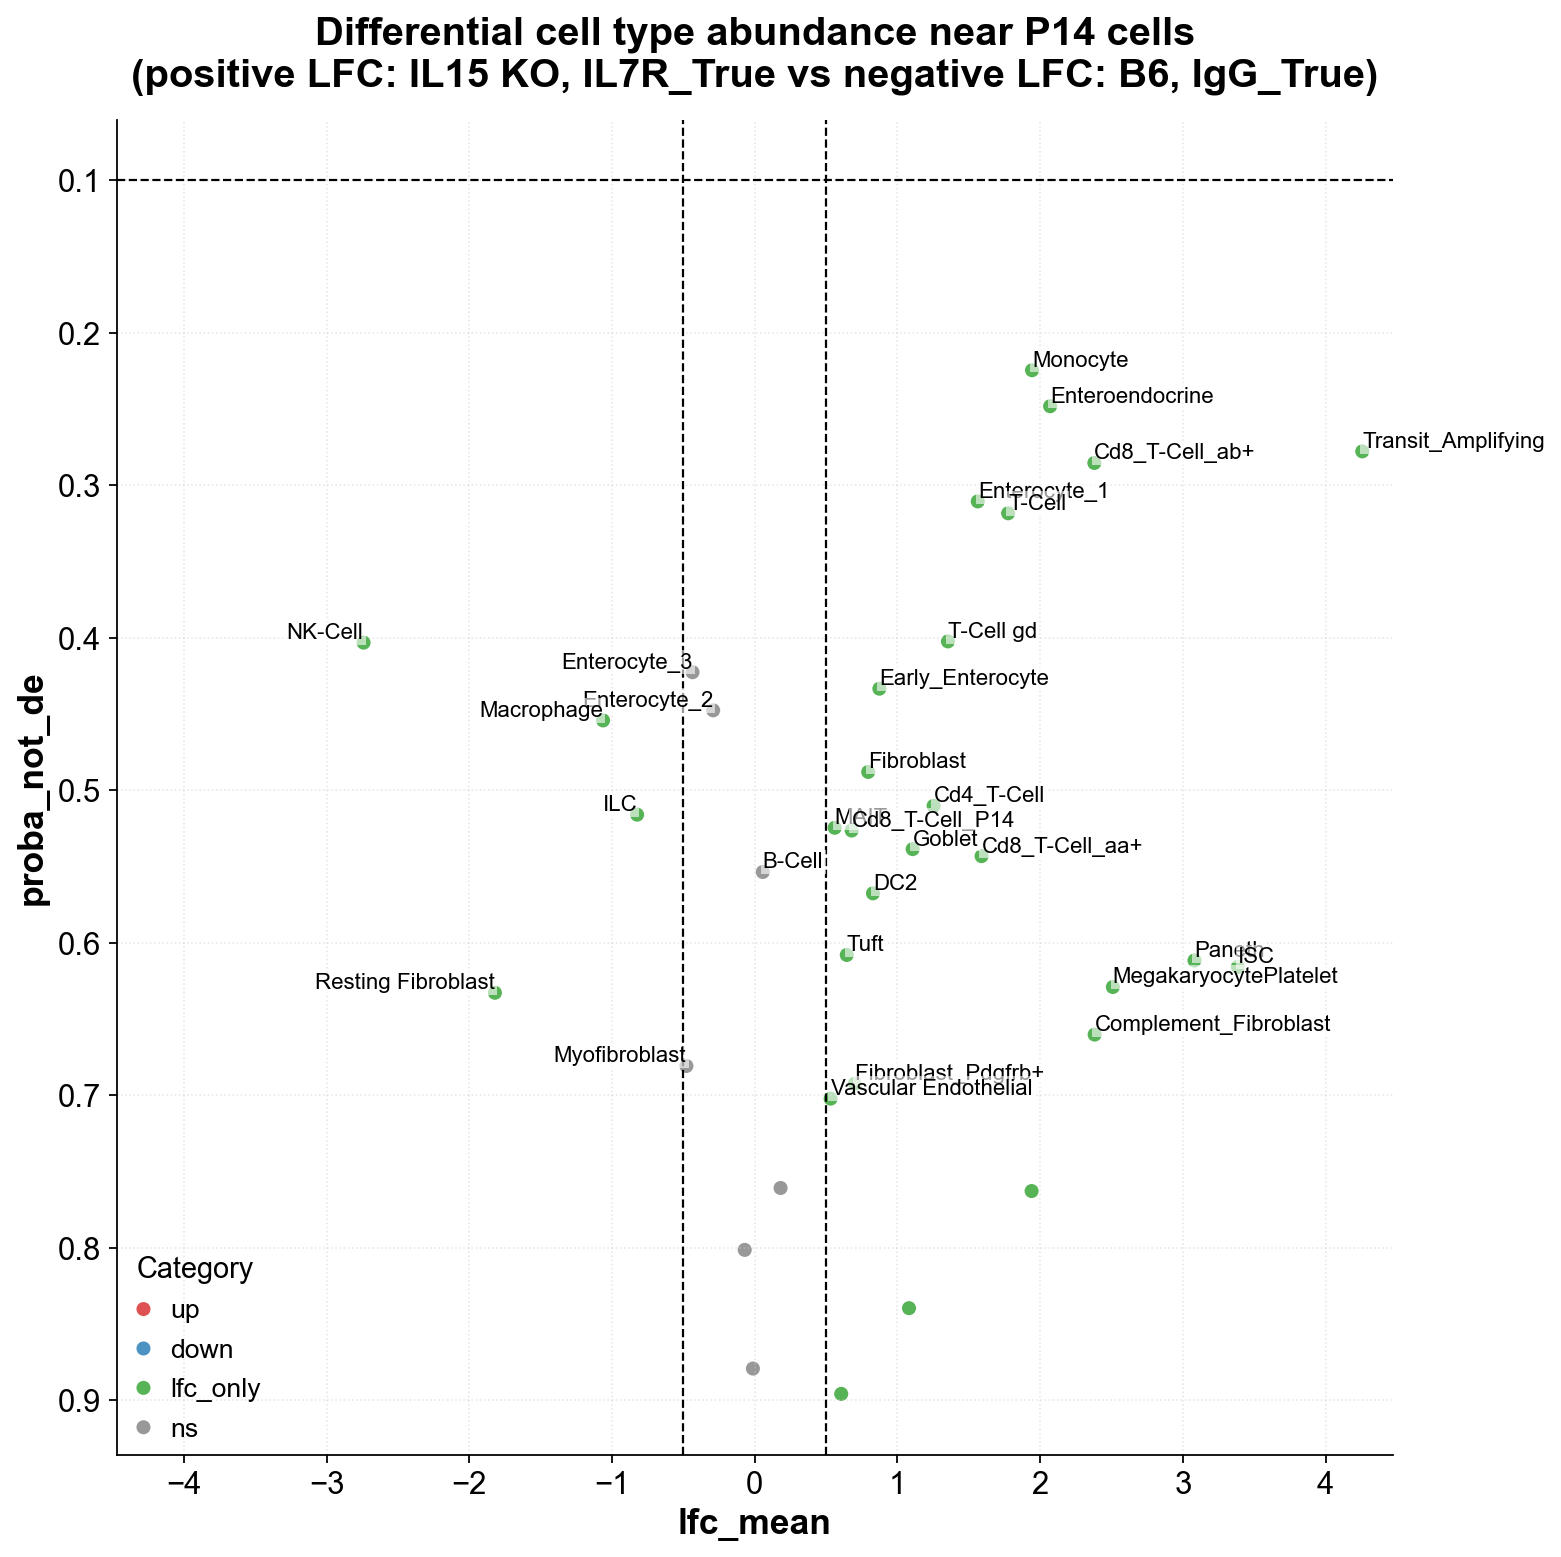

In [52]:
batch1 = 'IL15 KO, IL7R_True'
batch2 = 'B6, IgG_True'
# Example usage (assuming `da_15`, `batch1`, and `batch2` are defined):
fig, ax = plot_volcano_matplotlib(
    da_15_7,
    batch1,
    batch2, 
    x="lfc_mean",
    y="proba_not_de",
    sign_thr=0.1,
    lfc_thr=0.5,
    top_n=30,
    figsize=(10, 10),
    invert_y=True,
)

plt.show()

/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)
/home/amonell/mambaforge/envs/resolVI/lib/python3.11/site-packages/seaborn/matrix.py:1113: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(**tight_params)
/tmp/ipykernel_218242/881199631.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


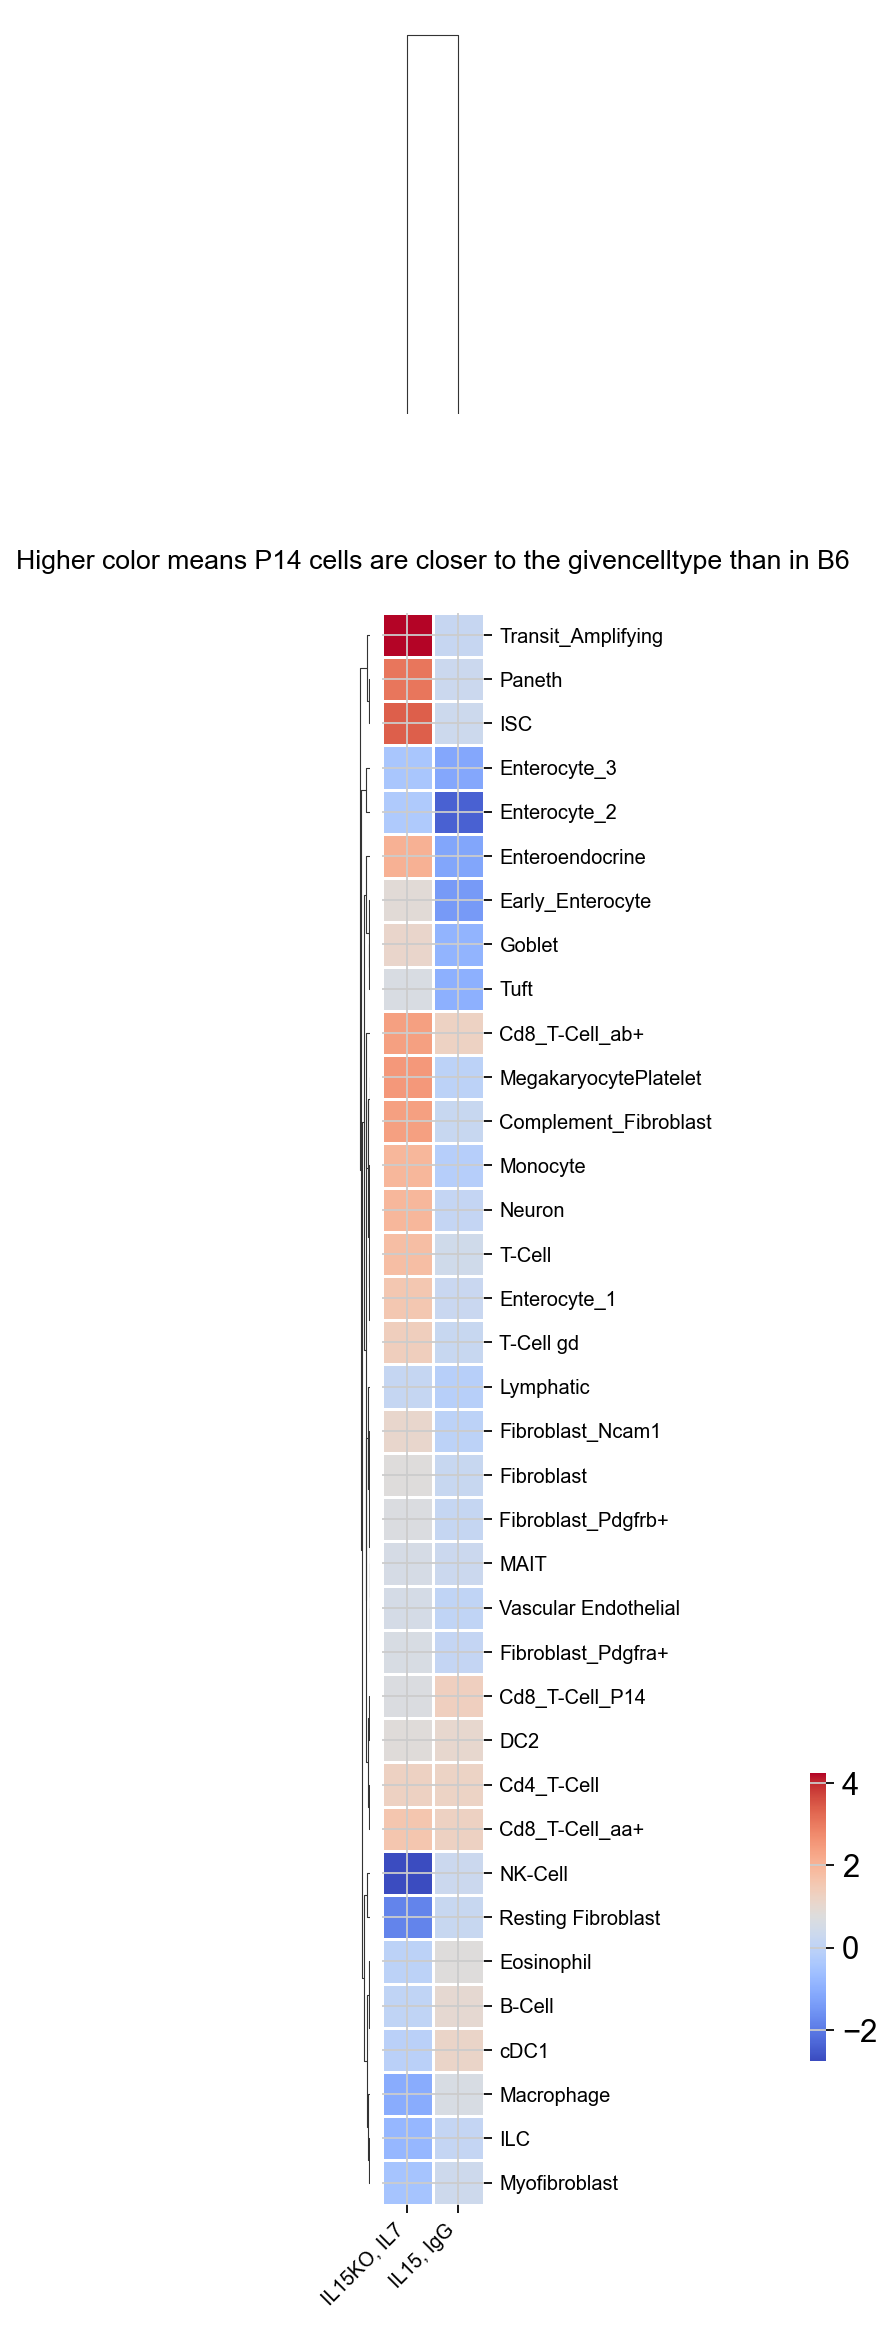

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Concatenate the two DataFrames as before ---
da_15_7_15 = pd.concat(
    [da_15_7[['lfc_mean']], da_15[['lfc_mean']]],
    axis=1
)
da_15_7_15.columns = ['IL15KO, IL7', 'IL15, IgG']

# --- 2. Compute a “square‐cell” figsize ---
n_rows, n_cols = da_15_7_15.shape
scale = 0.5  # tweak up/down to taste
fig_height = n_rows * scale
fig_width  = n_cols * scale

# --- 3. Draw clustermap with coolwarm and colorbar on the right ---
cluster_grid = sns.clustermap(
    da_15_7_15,
    cmap='coolwarm',     # use coolwarm instead of viridis
    square=True,          
    figsize=(fig_width, fig_height),
    linewidths=0.5,
    linecolor='white',
    dendrogram_ratio=(0.1, 0.2),
    # Move cbar to the right: (x, y, width, height) in figure coords
    cbar_pos=(3, 0.20, 0.1, 0.1),
    yticklabels=True,     
    xticklabels=True      
)

# --- 4. Rotate tick labels so they don’t overlap ---
cluster_grid.ax_heatmap.set_xticklabels(
    cluster_grid.ax_heatmap.get_xticklabels(),
    rotation=45,
    ha='right',
    fontsize=9
)
cluster_grid.ax_heatmap.set_yticklabels(
    cluster_grid.ax_heatmap.get_yticklabels(),
    rotation=0,
    fontsize=9
)

cluster_grid.ax_heatmap.set_title(
    "Higher color means P14 cells are closer to the givencelltype than in B6",
    pad=20,
    fontsize=12
)

plt.tight_layout()
plt.show()
